In [1]:
!pip install numpy
!pip install cplex
!pip install qiskit-optimization

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


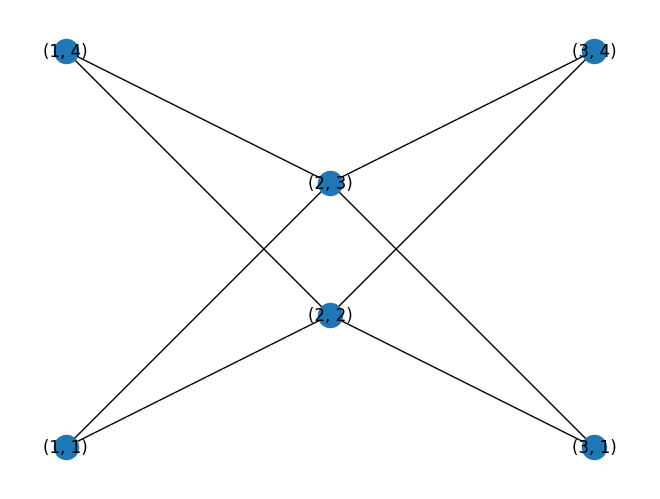

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()


points1 = [] #placement of lidars for one side
points2 = [] #placement of lidars for other side
points3 = [] #vertices to cover


for i in range(1, 4, 2):
    point = (i, 1)
    points1.append(point)

for i in range(1, 4, 2):
    point = (i, 4)
    points2.append(point)

for i in range(2, 3):
    for j in range(2, 4):
        point = (i, j)
        points3.append(point)

G.add_nodes_from(points1 + points2 + points3)


#edge that represents scope between lidar placement and vertices to cover
for node1 in points1:
  for j in range (node1[1]+1, node1[1]+3):
    if(j==node1[1]+1):
      for i in range(node1[0]-2, node1[0]+3):
        if (i,j) in points3:
          G.add_edge(tuple(node1), (i,j))
    if(j== node1[1]+2):
      for i in range(node1[0]-1, node1[0]+2):
        if (i,j) in points3:
          G.add_edge(tuple(node1), (i,j))
for node2 in points2:
  for j in range (node2[1]-2,node2[1]):
    if(j== node2[1]-2):
      for i in range(node2[0]-1, node2[0]+2):
        if (i,j) in points3:
          G.add_edge(tuple(node2), (i,j))
    if(j==node2[1]-1):
      for i in range(node2[0]-2, node2[0]+3):
        if (i,j) in points3:
          G.add_edge(tuple(node2), (i,j))

#Draw the graph

pos = {node: node for node in G.nodes()} 
nx.draw(G, pos,with_labels=True)

# plt.xlim(-1, 13)
# plt.ylim(-2, 7)

# plt.xticks(range(0, 13))
# plt.yticks(range(1, 7))

plt.show()

def showGraph(G, S):


    actE =[]
    for node in S:
      for edge in G.edges(node):
        actE.append(edge)
    # Draw the graph
    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, with_labels=True)

    nx.draw_networkx_nodes(G, pos, S, node_color='red')
    nx.draw_networkx_edges(G, pos, actE, edge_color='red')
    plt.show()


In [3]:
import os
from platform import node
import numpy as np
import qiskit_optimization
from docplex.mp.model import Model
from qiskit_optimization.problems import QuadraticProgram
import networkx as nx
import re

# $x = O(V_1)$ $y = O(E)$

// This file has been generated by DOcplex
// model name is: BMW
// var contrainer section
dvar bool x[4];
dvar bool y[8];

minimize
 x_1_1 + x_3_1 + x_1_4 + x_3_4;
 
subject to {
 y_(1,_1)_(2,_2) + y_(3,_1)_(2,_2) + y_(1,_4)_(2,_2) + y_(3,_4)_(2,_2) <= 4;
 y_(1,_1)_(2,_2) + y_(3,_1)_(2,_2) + y_(1,_4)_(2,_2) + y_(3,_4)_(2,_2) >= 1;
 y_(1,_1)_(2,_3) + y_(3,_1)_(2,_3) + y_(1,_4)_(2,_3) + y_(3,_4)_(2,_3) <= 4;
 y_(1,_1)_(2,_3) + y_(3,_1)_(2,_3) + y_(1,_4)_(2,_3) + y_(3,_4)_(2,_3) >= 1;
 y_(1,_1)_(2,_2) - 2 x_1_1 + y_(1,_1)_(2,_3) == 0;
 y_(3,_1)_(2,_2) - 2 x_3_1 + y_(3,_1)_(2,_3) == 0;
 y_(1,_4)_(2,_2) - 2 x_1_4 + y_(1,_4)_(2,_3) == 0;
 y_(3,_4)_(2,_2) - 2 x_3_4 + y_(3,_4)_(2,_3) == 0;

}
None
output =  // This file has been generated by DOcplex
// model name is: BMW
// var contrainer section
dvar bool x[4];
dvar bool y[8];

minimize
 x_1_1 + x_3_1 + x_1_4 + x_3_4;
 
subject to {
 y_(1,_1)_(2,_2) + y_(3,_1)_(2,_2) + y_(1,_4)_(2,_2) + y_(3,_4)_(2,_2) <= 4;
 y_(1,_1)_(2,_2) + y_(3,_1)_(2,_2

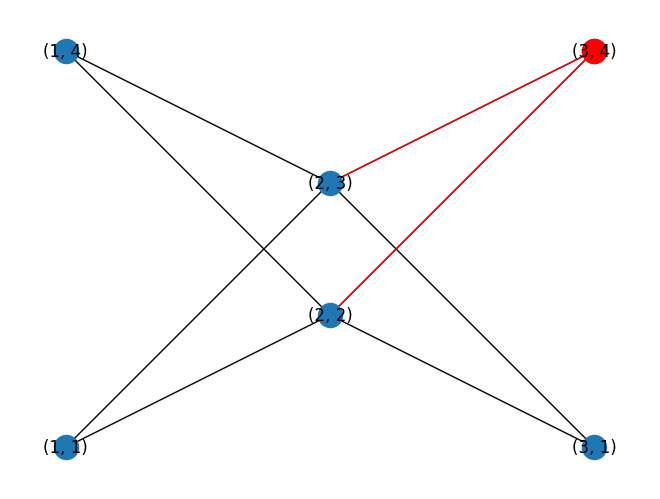

In [4]:
tabR = []
m = Model(name='BMW')
pointsL = points1 + points2
x = m.binary_var_dict(pointsL, name='x')
m.objective_expr = sum(x[i] for i in pointsL) #minimize the placement of lidars
m.objective_sense = 'min'
#z = m.integer_var_dict(G.nodes(degree), name='z')
y = m.binary_var_dict(G.edges, name='y')
#constraint on edge covering all vertices (allows to ensure that at least one lidar covers the area)
for node in points3:
  degree = len(G.edges(node))
  adjEdges = [(i[1], i[0]) for i in G.edges(node)]
  m.add_constraint(sum(y[i] for i in adjEdges) <= degree)
  m.add_constraint(sum(y[i] for i in adjEdges) >= 1)

#Link the relation between edge activation and lidar placement activation

for node in pointsL:
  m.add_constraint(sum(y[i] - x[node] for i in G.edges(node) if i[0] == node) == 0)

print(m.prettyprint())
output = m.pprint_as_string()
print("output = ", output)
values = re.findall(r'\[(.*?)\]', output)
valueT = 0
for value in values:
    #print(value)
    valueT = int(value)+valueT
tabR.append(valueT)
print('tabR = ', tabR)
m.export_as_lp(basename="BMW1", path=os.path.abspath(""))
sol_model = m.solve()
m.print_solution()
S = []
for (x, y) in sol_model.iter_var_values():
  sx = str(x)
  if sx[0] == 'x':
    S.append((int(sx[2]), int(sx[4])))
showGraph(G, S)
#dvar bool x[6];
#dvar bool y[44];

# $x = O(V_1)$ $y = O(V_2)$ $s = O(deg(V_2))$

4
// This file has been generated by DOcplex
// model name is: BMW
// var contrainer section
dvar bool x[4];
dvar int y[2];

minimize
 x_1_1 + x_3_1 + x_1_4 + x_3_4;
 
subject to {
 y_2_2 <= 4;
 y_2_2 >= 1;
 y_2_3 <= 4;
 y_2_3 >= 1;
 y_2_2 == x_1_1 + x_3_1 + x_1_4 + x_3_4;
 y_2_3 == x_1_1 + x_3_1 + x_1_4 + x_3_4;

}
None
tabR =  [12, 6]
objective: 1
status: OPTIMAL_SOLUTION(2)
  x_1_1=1
  y_2_2=1
  y_2_3=1


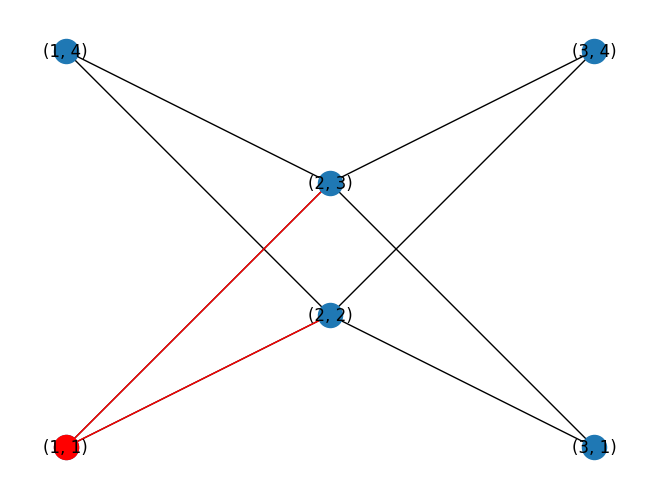

In [5]:
m = Model(name='BMW')
pointsL = points1 + points2
x = m.binary_var_dict(pointsL, name='x')
m.objective_expr = sum(x[i] for i in pointsL) #minimize the placement of lidars
m.objective_sense = 'min'

max_deg = 0

for v in G.nodes():
    v_deg = G.degree[v]
    if max_deg <= v_deg:
        max_deg = v_deg

print(max_deg)

y = m.integer_var_dict(points3, name='y',lb=0, ub=max_deg)

#constraint on edge covering all vertices (allows to ensure that at least one lidar covers the area)
for node in points3:
    m.add_constraint(y[node] <= G.degree[node])
    m.add_constraint(y[node] >= 1)

#Link the relation between edge activation and lidar placement activation
for node in points3:
    m.add_constraint(y[node] == sum(x[v] for v in G.neighbors(node)))

print(m.prettyprint())
output = m.pprint_as_string()
values = re.findall(r'\[(.*?)\]', output)
valueT = 0
for value in values:
    #print(value)
    valueT = int(value)+valueT
tabR.append(valueT)
print('tabR = ', tabR)
m.export_as_lp(basename="BMW2", path=os.path.abspath(""))
sol_model = m.solve()
m.print_solution()
S = []
for (x, y) in sol_model.iter_var_values():
  sx = str(x)
  if sx[0] == 'x':
    S.append((int(sx[2]), int(sx[4])))
showGraph(G, S)
#dvar bool x[6];
#dvar bool y[14];

 # $x = O(V_1)$ $y = \sum(O(deg(V_2)))$

// This file has been generated by DOcplex
// model name is: BMW
// var contrainer section
dvar bool x[4];
dvar bool z_(2, 2)[4];
dvar bool z_(2, 3)[4];

minimize
 x_1_1 + x_3_1 + x_1_4 + x_3_4;
 
subject to {
 z_(2,_2)_0 + z_(2,_2)_1 + z_(2,_2)_2 + z_(2,_2)_3 >= 1;
 z_(2,_3)_0 + z_(2,_3)_1 + z_(2,_3)_2 + z_(2,_3)_3 >= 1;
 z_(2,_2)_0 + z_(2,_2)_1 + z_(2,_2)_2 + z_(2,_2)_3 == x_1_1 + x_3_1 + x_1_4
 + x_3_4;
 z_(2,_3)_0 + z_(2,_3)_1 + z_(2,_3)_2 + z_(2,_3)_3 == x_1_1 + x_3_1 + x_1_4
 + x_3_4;

}
None
tabR [12, 6, 12]
objective: 1
status: OPTIMAL_SOLUTION(2)
  "x_1_1"=1
  "z_(2, 2)_2"=1
  "z_(2, 3)_1"=1


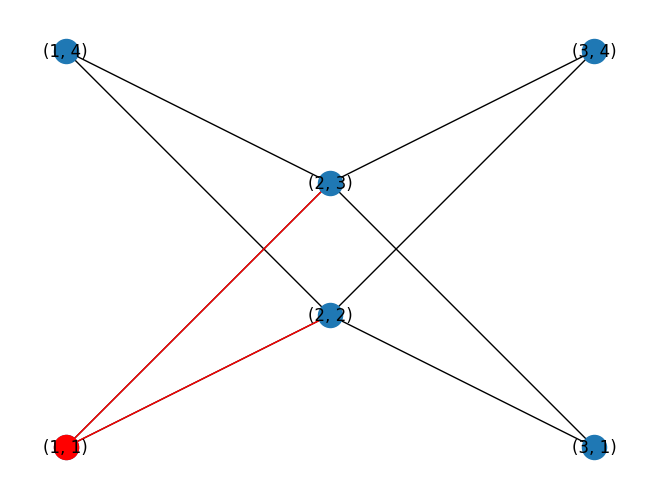

In [6]:
m = Model(name='BMW') #compare result log complexity graph generator function that compare quality of the result evaluating resumt (numbre of nodes & number of qubit)
#ten node how to compare how many qubit needs for alll approach and bard thing??? 3 items and x number qubit need quality of nulmber of acticvate node 
#do the pubo on simulating annnealing threatten sa function can be re-use 
pointsL = points1 + points2
x = m.binary_var_dict(pointsL, name='x') 
m.objective_expr = sum(x[i] for i in pointsL) #minimize the placement of lidars
m.objective_sense = 'min'

#max_deg = max(G.degree(v) for v in G.nodes())
#y = m.integer_var_dict(points3, lb=0, ub=max_deg, name='y') 
# y = [m.binary_var_dict(G.degree(node), name='z_'+str(node)) for node in points3]

# #constraint on number of activate edge
# for node in points3:
#     m.add_constraint(sum(y[G.degree(node)].values()) >= 1)
#     m.add_constraint(sum(y[G.degree(node)].values()) <= G.degree(node))
#     print("y[G.degree(node).value]  ==  ",y[G.degree(node)].values())

# #constraint link active edge and node
# for node in points3:
#     m.add_constraint(sum(y[G.degree(node)].values()) == sum(x[v] for v in G.neighbors(node)))

y = {node:m.binary_var_list(G.degree(node), name='z_'+str(node)) for node in points3}
for node in points3:
    m.add_constraint(sum(y[node]) >= 1)

for node in points3:
    m.add_constraint(sum(y[node]) == sum(x[v] for v in G.neighbors(node)))

print(m.prettyprint())

output = m.pprint_as_string()
values = re.findall(r'\[(.*?)\]', output)
valueT = 0
for value in values:
    #print(value)
    valueT = int(value)+valueT
tabR.append(valueT)
print("tabR", tabR)
m.export_as_lp(basename="BMW3", path=os.path.abspath(""))
sol_model = m.solve()
m.print_solution()
S = []
for (x, y) in sol_model.iter_var_values():
  sx = str(x)
  if sx[0] == 'x':
    S.append((int(sx[2]), int(sx[4])))
showGraph(G, S)
# dvar bool x[6];
# dvar bool z_(0, 2)[2];
# dvar bool z_(0, 3)[2];
# dvar bool z_(1, 2)[3];
# dvar bool z_(1, 3)[3];
# dvar bool z_(2, 2)[4];
# dvar bool z_(2, 3)[4];
# dvar bool z_(3, 2)[4];
# dvar bool z_(3, 3)[4];
# dvar bool z_(4, 2)[4];
# dvar bool z_(4, 3)[4];
# dvar bool z_(5, 2)[3];
# dvar bool z_(5, 3)[3];
# dvar bool z_(6, 2)[2];
# dvar bool z_(6, 3)[2];
#44 z

// This file has been generated by DOcplex
// model name is: BMW
// var contrainer section
dvar bool x[4];

minimize
 x_1_1 + x_3_1 + x_1_4 + x_3_4;
 
subject to {
 x_1_1 + x_3_1 + x_1_4 + x_3_4 >= 1;
 x_1_1 + x_3_1 + x_1_4 + x_3_4 >= 1;

}
None
tabR [12, 6, 12, 4]
objective: 1
status: OPTIMAL_SOLUTION(2)
  x_1_1=1


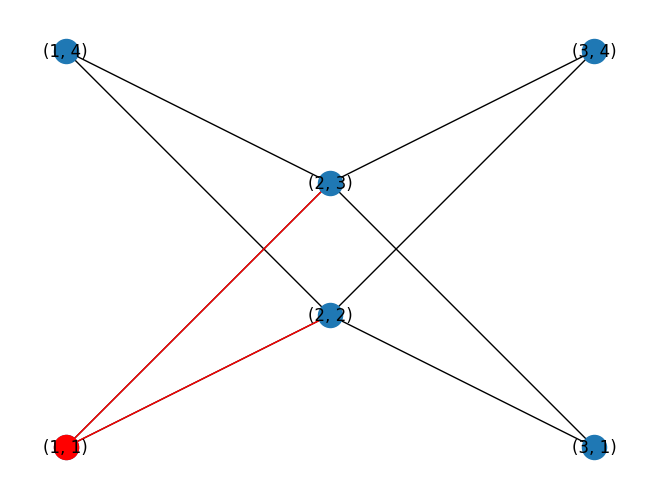

In [7]:
m = Model(name='BMW') #compare result log complexity graph generator function that compare quality of the result evaluating resumt (numbre of nodes & number of qubit)
#ten node how to compare how many qubit needs for alll approach and bard thing??? 3 items and x number qubit need quality of nulmber of acticvate node 
#do the pubo on simulating annnealing threatten sa function can be re-use 
pointsL = points1 + points2
x = m.binary_var_dict(pointsL, name='x') 
m.objective_expr = sum(x[i] for i in pointsL) #minimize the placement of lidars
m.objective_sense = 'min'

for node in points3:
    m.add_constraint(1 <= sum(x[v] for v in G.neighbors(node)))
print(m.prettyprint())

output = m.pprint_as_string()
values = re.findall(r'\[(.*?)\]', output)
valueT = 0
for value in values:
    #print(value)
    valueT = int(value)+valueT
tabR.append(valueT)
print("tabR", tabR)
m.export_as_lp(basename="BMW4", path=os.path.abspath(""))
sol_model = m.solve()
m.print_solution()
S = []
for (x, y) in sol_model.iter_var_values():
  sx = str(x)
  if sx[0] == 'x':
    S.append((int(sx[2]), int(sx[4])))
showGraph(G, S)

// This file has been generated by DOcplex
// model name is: BMW
// var contrainer section
dvar bool x[4];

minimize
 x_1_1 + x_3_1 + x_1_4 + x_3_4;
 
subject to {
 x_1_1 + x_3_1 + x_1_4 + x_3_4 == 1;
 x_1_1 + x_3_1 + x_1_4 + x_3_4 == 1;

}
None
tabR [12, 6, 12, 4, 4]
objective: 1
status: OPTIMAL_SOLUTION(2)
  x_1_1=1


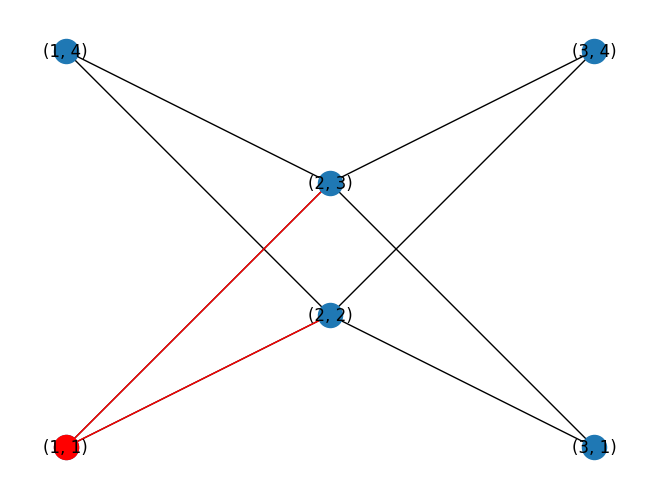

In [8]:
m = Model(name='BMW') #compare result log complexity graph generator function that compare quality of the result evaluating resumt (numbre of nodes & number of qubit)
#ten node how to compare how many qubit needs for alll approach and bard thing??? 3 items and x number qubit need quality of nulmber of acticvate node 
#do the pubo on simulating annnealing threatten sa function can be re-use 
pointsL = points1 + points2
x = m.binary_var_dict(pointsL, name='x') 
m.objective_expr = sum(x[i] for i in pointsL) #minimize the placement of lidars
m.objective_sense = 'min'

for node in points3:
    m.add_constraint(1 == sum(x[v] for v in G.neighbors(node)))
print(m.prettyprint())

output = m.pprint_as_string()
values = re.findall(r'\[(.*?)\]', output)
valueT = 0
for value in values:
    #print(value)
    valueT = int(value)+valueT
tabR.append(valueT)
print("tabR", tabR)
m.export_as_lp(basename="BMW5", path=os.path.abspath(""))
sol_model = m.solve()
m.print_solution()
S = []
for (x, y) in sol_model.iter_var_values():
  sx = str(x)
  if sx[0] == 'x':
    S.append((int(sx[2]), int(sx[4])))
showGraph(G, S)

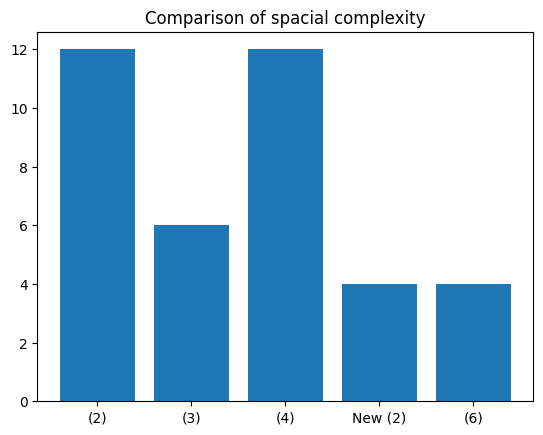

In [9]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["(2)", "(3)", "(4)", "New (2)", "(6)"])
y = np.array(tabR)
plt.title("Comparison of spacial complexity")
plt.bar(x,y)
plt.show()

In [10]:
quadratic_program1 = QuadraticProgram()
quadratic_program2 = QuadraticProgram()
quadratic_program3 = QuadraticProgram()
quadratic_program4 = QuadraticProgram()
quadratic_program5 = QuadraticProgram()
quadratic_program1.read_from_lp_file(os.path.join(os.path.abspath(""), 'BMW1.lp'))
quadratic_program2.read_from_lp_file(os.path.join(os.path.abspath(""), 'BMW2.lp'))
quadratic_program3.read_from_lp_file(os.path.join(os.path.abspath(""), 'BMW3.lp'))
quadratic_program4.read_from_lp_file(os.path.join(os.path.abspath(""), 'BMW4.lp'))
quadratic_program5.read_from_lp_file(os.path.join(os.path.abspath(""), 'BMW5.lp'))
print("quadratic program 1 = ", quadratic_program1.prettyprint())
print("quadratic program 2 = ", quadratic_program2.prettyprint())
print("quadratic program 3 = ", quadratic_program3.prettyprint())
print("quadratic program 4 = ", quadratic_program4.prettyprint())
print("quadratic program 5 = ", quadratic_program5.prettyprint())
#print(len(quadratic_program1.linear_constraints_index))
#50 binary variables from the first program
#14 integer variables and 6 binary variable from the second program
#16 binary variables from the third program

quadratic program 1 =  Problem name: BMW

Minimize
  x_1_1 + x_1_4 + x_3_1 + x_3_4

Subject to
  Linear constraints (8)
    y_(1,_1)_(2,_2) + y_(1,_4)_(2,_2) + y_(3,_1)_(2,_2) + y_(3,_4)_(2,_2)
    <= 4  'c1'
    y_(1,_1)_(2,_2) + y_(1,_4)_(2,_2) + y_(3,_1)_(2,_2) + y_(3,_4)_(2,_2)
    >= 1  'c2'
    y_(1,_1)_(2,_3) + y_(1,_4)_(2,_3) + y_(3,_1)_(2,_3) + y_(3,_4)_(2,_3)
    <= 4  'c3'
    y_(1,_1)_(2,_3) + y_(1,_4)_(2,_3) + y_(3,_1)_(2,_3) + y_(3,_4)_(2,_3)
    >= 1  'c4'
    -2*x_1_1 + y_(1,_1)_(2,_2) + y_(1,_1)_(2,_3) == 0  'c5'
    -2*x_3_1 + y_(3,_1)_(2,_2) + y_(3,_1)_(2,_3) == 0  'c6'
    -2*x_1_4 + y_(1,_4)_(2,_2) + y_(1,_4)_(2,_3) == 0  'c7'
    -2*x_3_4 + y_(3,_4)_(2,_2) + y_(3,_4)_(2,_3) == 0  'c8'

  Binary variables (12)
    x_1_1 x_3_1 x_1_4 x_3_4 y_(1,_1)_(2,_2) y_(3,_1)_(2,_2) y_(1,_4)_(2,_2)
    y_(3,_4)_(2,_2) y_(1,_1)_(2,_3) y_(3,_1)_(2,_3) y_(1,_4)_(2,_3)
    y_(3,_4)_(2,_3)

quadratic program 2 =  Problem name: BMW

Minimize
  x_1_1 + x_1_4 + x_3_1 + x_3_4

Subject to

qp1 =  minimize 5*c1@int_slack@0^2 + 20*c1@int_slack@0*c1@int_slack@1 + 10*c1@int_slack@0*c1@int_slack@2 + 20*c1@int_slack@1^2 + 20*c1@int_slack@1*c1@int_slack@2 + 5*c1@int_slack@2^2 + 5*c2@int_slack@0^2 + 20*c2@int_slack@0*c2@int_slack@1 + 20*c2@int_slack@1^2 + 5*c3@int_slack@0^2 + 20*c3@int_slack@0*c3@int_slack@1 + 10*c3@int_slack@0*c3@int_slack@2 + 20*c3@int_slack@1^2 + 20*c3@int_slack@1*c3@int_slack@2 + 5*c3@int_slack@2^2 + 5*c4@int_slack@0^2 + 20*c4@int_slack@0*c4@int_slack@1 + 20*c4@int_slack@1^2 + 20*x_1_1^2 - 20*x_1_1*y_(1,_1)_(2,_2) - 20*x_1_1*y_(1,_1)_(2,_3) + 20*x_1_4^2 - 20*x_1_4*y_(1,_4)_(2,_2) - 20*x_1_4*y_(1,_4)_(2,_3) + 20*x_3_1^2 - 20*x_3_1*y_(3,_1)_(2,_2) - 20*x_3_1*y_(3,_1)_(2,_3) + 20*x_3_4^2 - 20*x_3_4*y_(3,_4)_(2,_2) - 20*x_3_4*y_(3,_4)_(2,_3) + 10*y_(1,_1)_(2,_2)*c1@int_slack@0 + 20*y_(1,_1)_(2,_2)*c1@int_slack@1 + 10*y_(1,_1)_(2,_2)*c1@int_slack@2 - 10*y_(1,_1)_(2,_2)*c2@int_slack@0 - 20*y_(1,_1)_(2,_2)*c2@int_slack@1 + 15*y_(1,_1)_(2,_2)^2 + 10*y_(1,_1)_(2,_2)*

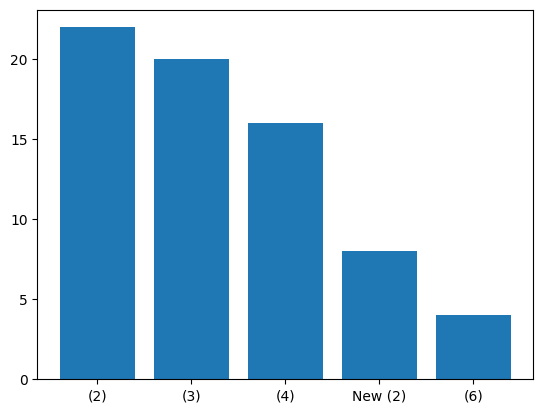

In [11]:
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.problems import VarType

conv = QuadraticProgramToQubo()
qp1 = conv.convert(quadratic_program1)
qp2 = conv.convert(quadratic_program2)
qp3 = conv.convert(quadratic_program3)
qp4 = conv.convert(quadratic_program4)
qp5 = conv.convert(quadratic_program5)
print("qp1 = ", qp1)
print("qp2 = ", qp2)
print("qp3 = ", qp3)
print("qp4 = ", qp4)
print("qp5 = ", qp5)
bin_num = []
bin_vars1 = []
for var in qp1.variables:
    if var.vartype is VarType.BINARY:
        bin_vars1.append(var.name)
bin_num.append(len(bin_vars1))
bin_vars2 = []
for var in qp2.variables:
    if var.vartype is VarType.BINARY:
        bin_vars2.append(var.name)
bin_num.append(len(bin_vars2))
bin_vars3 = []
for var in qp3.variables:
    if var.vartype is VarType.BINARY:
        bin_vars3.append(var.name)
bin_num.append(len(bin_vars3))
bin_vars4 = []
for var in qp4.variables:
    if var.vartype is VarType.BINARY:
        bin_vars4.append(var.name)
bin_num.append(len(bin_vars4))
bin_vars5 = []
for var in qp5.variables:
    if var.vartype is VarType.BINARY:
        bin_vars5.append(var.name)
bin_num.append(len(bin_vars5))
x = np.array(["(2)", "(3)", "(4)", "New (2)", "(6)"])
y = np.array(bin_num)

plt.bar(x,y)
plt.show()